In [4]:
import numpy as np
import matplotlib.pyplot as plt
loaded_data = np.load('E_field_data_combined_extended.npz' , allow_pickle=True)
print(loaded_data)
E_data_combined = loaded_data['data']
print(type(E_data_combined))  # To check the type of the loaded data
print(E_data_combined.shape)

<class 'numpy.ndarray'>
(8944, 5)


Normalized Training Set X Shape: (6708, 4) X dtype: float32
Normalized Training Set y Shape: (6708, 97, 177) y dtype: float32
Normalized Validation Set X Shape: (1341, 4) X dtype: float32
Normalized Validation Set y Shape: (1341, 97, 177) y dtype: float32
Normalized Test Set X Shape: (895, 4) X dtype: float32
Normalized Test Set y Shape: (895, 97, 177) y dtype: float32
(17169,)
(97, 177)


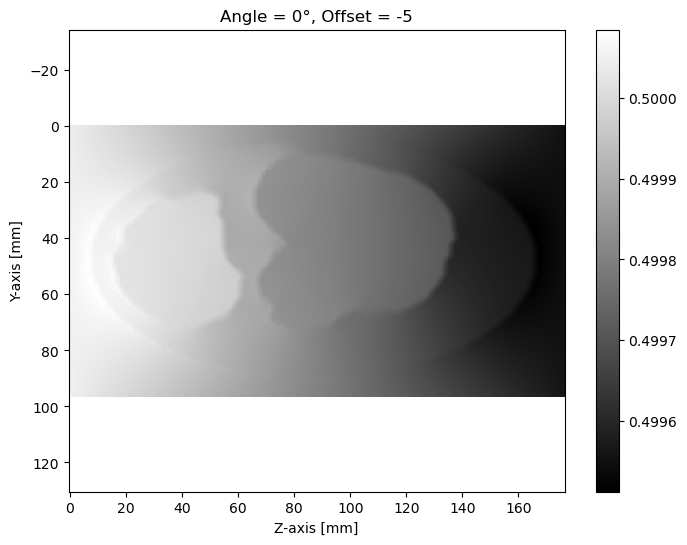

In [5]:
import numpy as np
E_data_combined = loaded_data["data"]

# Split features (first four columns) and matrices (last column)
conditions = E_data_combined[:, :-1].astype(np.float32)  # Convert feature data to float32
matrices = np.array([np.array(matrix, dtype=np.float32) for matrix in E_data_combined[:, -1]])  # Convert matrices

# Normalize conditions
# conditions_min = conditions.min(axis=0)
# conditions_max = conditions.max(axis=0)
# X_normalized = (conditions - conditions_min) / (conditions_max - conditions_min)
X_normalized = conditions
# Randomly shuffle the data to avoid overfitting
num_samples = X_normalized.shape[0]
indices = np.random.permutation(num_samples)  # Shuffle the indices
X_normalized_shuffled = X_normalized[indices]
y_normalized_shuffled = matrices[indices]

# Calculate indices for training, validation, and test splits
train_size = int(0.75 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size  # Ensure all data is used

# Split the shuffled data into training, validation, and test sets
X_train_1, y_train_1 = X_normalized_shuffled[:train_size], y_normalized_shuffled[:train_size]
X_val_1, y_val_1 = X_normalized_shuffled[train_size:train_size + val_size], y_normalized_shuffled[train_size:train_size + val_size]
X_test_1, y_test_1 = X_normalized_shuffled[train_size + val_size:], y_normalized_shuffled[train_size + val_size:]


y_train_1 = y_train_1[:, 2:99, 2:179]
y_val_1 = y_val_1[:, 2:99, 2:179]
y_test_1 = y_test_1[:, 2:99, 2:179]

y_train_1 = (y_train_1 + 1) / 2.0
y_val_1 = (y_val_1 + 1) / 2.0
y_test_1 = (y_test_1 + 1) / 2.0
# Print detailed information about all normalized and split data sets
print("Normalized Training Set X Shape:", X_train_1.shape, "X dtype:", X_train_1.dtype)
print("Normalized Training Set y Shape:", y_train_1.shape, "y dtype:", y_train_1.dtype)
print("Normalized Validation Set X Shape:", X_val_1.shape, "X dtype:", X_val_1.dtype)
print("Normalized Validation Set y Shape:", y_val_1.shape, "y dtype:", y_val_1.dtype)
print("Normalized Test Set X Shape:", X_test_1.shape, "X dtype:", X_test_1.dtype)
print("Normalized Test Set y Shape:", y_test_1.shape, "y dtype:", y_test_1.dtype)
# Check and reshape y_test_1 for visualization
a_check = y_test_1[0].flatten()
print(a_check.shape)
a_check = a_check.reshape(97, 177)
print(a_check.shape)
selected_index = 89
angle, offset, direction, _, Ex_data = E_data_combined[selected_index]

plt.figure(figsize=(8, 6))
img = plt.imshow(a_check, cmap='gray')  # Visualize only the relevant slice of Ex_data

# Set titles and labels
plt.title(f'Angle = {angle}°, Offset = {offset}')
plt.xlabel('Z-axis [mm]')
plt.ylabel('Y-axis [mm]')
plt.axis('equal')  # Maintain equal aspect ratio for better visualization
plt.colorbar(img)  # Add a color bar for scale

# Show the single image
plt.show()


model is overfitting , so trying with some learning rate 

## Now , we are update the code and use the the check point and droupout and earily stopping  

plot the best_model.h5 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# Define the model with L2 regularization and Dropout
model = Sequential([
    Dense(4, activation='relu', input_shape=(X_train_1.shape[1],), kernel_regularizer=l2(0.001)),  # Input layer with L2 regularization
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(2**5, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(2**7, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(2**9, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(2**11, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(2**13, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(17169, activation='linear')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

# Create callbacks for early stopping and model checkpoints
checkpoint = ModelCheckpoint('best_model_linear_update.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Print model summary
model.summary()

# Assuming X_train, y_train_flat, X_val, y_val_flat are defined and prepared
y_train_flat = np.array([y.reshape(-1) for y in y_train_1])
y_val_flat = np.array([y.reshape(-1) for y in y_val_1])

# Train the model with the callbacks
history = model.fit(X_train_1, y_train_flat,
                    validation_data=(X_val_1, y_val_flat),
                    epochs=100, batch_size=16, verbose=1,
                    callbacks=[checkpoint, early_stopping])

# Function to plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis ticks with custom spacing
    y_ticks = np.arange(0.01, max(max(history.history['loss']), max(history.history['val_loss'])) + 0.01, 0.5)
    plt.yticks(y_ticks)
    
    plt.show()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
# Plotting the training history
plot_history(history)


2024-11-26 17:02:33.147895: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-11-26 17:02:33.882986: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-11-26 17:02:33.883495: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-11-26 17:02:33.912337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA L40S computeCapability: 8.9
coreClock: 2.52GHz coreCount: 142 deviceMemorySize: 47.40GiB deviceMemoryBandwidth: 804.75GiB/s
2024-11-26 17:02:33.912355: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-11-26 17:02:33.913455: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-11-2

ResourceExhaustedError: OOM when allocating tensor with shape[8192,17169] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

: 

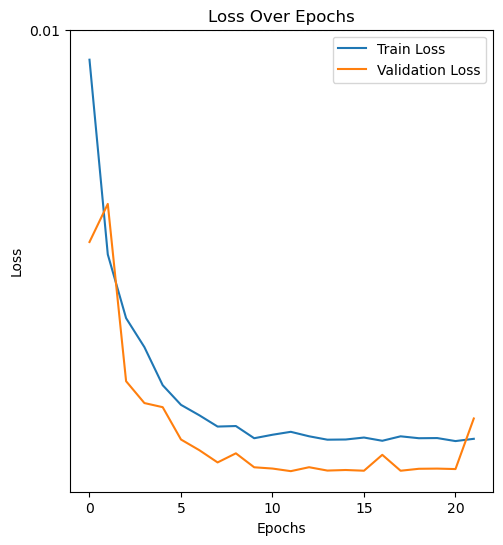

In [5]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'][1:], label='Train Loss')
    plt.plot(history.history['val_loss'][1:], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis ticks with custom spacing
    y_ticks = np.arange(0.01, max(max(history.history['loss'][1:]), max(history.history['val_loss'][1:])) + 0.01, 0.1)
    plt.yticks(y_ticks)
    
    plt.show()


    # plt.subplot(1, 2, 2)
    # plt.plot(history.history['accuracy'], label='Train Accuracy')
    # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    # plt.title('Accuracy Over Epochs')
    # plt.xlabel('Epochs')
    # plt.ylabel('Accuracy')
    # plt.legend()

    plt.show()
# Plotting the training history
plot_history(history)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('best_model_linear_update.h5')

# Make predictions
y_pred_best_model = model.predict(X_test_1)
y_test_flat = np.array([y.reshape(-1) for y in y_test_1])

# Calculate the mean absolute error and R^2 score
test_mse = mean_absolute_error(y_test_flat, y_pred_best_model)
test_r2 = r2_score(y_test_flat, y_pred_best_model)
print("Test MSE:", test_mse)
print("Test R^2 Score:", test_r2)


2024-11-26 19:07:47.086907: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-11-26 19:07:47.899478: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-11-26 19:07:47.900042: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-11-26 19:07:47.930649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA L40S computeCapability: 8.9
coreClock: 2.52GHz coreCount: 142 deviceMemorySize: 47.40GiB deviceMemoryBandwidth: 804.75GiB/s
2024-11-26 19:07:47.930672: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-11-26 19:07:47.931772: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-11-2

ResourceExhaustedError: OOM when allocating tensor with shape[8192,17169] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape y_test and y_pred for comparison
y_test_flat = np.array([y.reshape(-1) for y in y_test_1])
y_pred_flat = np.array([y.reshape(-1) for y in y_pred_best_model])
indices_to_plot = range(1)
for selected_index in indices_to_plot:
    y_test_selected = y_test_flat[selected_index].reshape(97, 177)
    y_pred_selected = y_pred_flat[selected_index].reshape(97, 177)
    plt.figure(figsize=(8, 6))
    img_actual = plt.imshow(y_test_selected, cmap='gray')  # Plot actual data slice
    plt.title(f'Actual Data for Test Sample {selected_index}')
    plt.xlabel('Z-axis [mm]')
    plt.ylabel('Y-axis [mm]')
    plt.colorbar(img_actual)  # Add a color bar for scale
    plt.show()

    # Plot predicted data
    plt.figure(figsize=(8, 6))
    img_pred = plt.imshow(y_pred_selected, cmap='gray')  # Plot predicted data slice
    plt.title(f'Predicted Data for Test Sample {selected_index}')
    plt.xlabel('Z-axis [mm]')
    plt.ylabel('Y-axis [mm]')
    plt.colorbar(img_pred)
    plt.show()
    plt.figure(figsize=(8, 6))
    img_diff = plt.imshow(np.abs(y_test_selected - y_pred_selected), cmap='gray')  # Plot difference
    plt.title(f'Difference between Actual and Predicted for Test Sample {selected_index}')
    plt.xlabel('Z-axis [mm]')
    plt.ylabel('Y-axis [mm]')
    plt.colorbar(img_diff)
    plt.show()
    print(f"Sample {selected_index} Prediction vs Actual (Flattened):")
    print("Predicted (First 10 values):", y_pred_flat[selected_index][:10])
    print("Actual (First 10 values):", y_test_flat[selected_index][:10])
    print("\n")


NameError: name 'y_pred_best_model' is not defined

: 

## now , we makeing dataset with conactinate with desirable image 

In [6]:
import numpy as np
loaded_nerve = np.load('nerve_2D_cross_section.npy')
loaded_nerve = loaded_nerve[2:99, 2:179]/5
print(loaded_nerve.max())
print("Loaded nerve shape:", loaded_nerve.shape)

1.0
Loaded nerve shape: (97, 177)


In [7]:
import numpy as np
from tensorflow.keras.models import load_model
model = load_model('best_model_linear_update.h5')
model.summary()
y_pred_best_model = model.predict(X_train_1)
print(y_pred_best_model.shape)
y_pred_flat = y_pred_best_model.reshape(6708,97,177)


2024-11-27 10:58:14.886525: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-11-27 10:58:15.694419: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-11-27 10:58:15.694923: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-11-27 10:58:15.788650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA L40S computeCapability: 8.9
coreClock: 2.52GHz coreCount: 142 deviceMemorySize: 47.40GiB deviceMemoryBandwidth: 804.75GiB/s
2024-11-27 10:58:15.788680: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-11-27 10:58:15.789920: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-11-2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               6

2024-11-27 10:58:36.747065: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-11-27 10:58:36.747362: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2999950000 Hz
2024-11-27 10:58:36.807209: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


(6708, 17169)


In [8]:
print(y_pred_flat.shape)

(6708, 97, 177)


In [9]:
new_dataset = []
for pred in y_pred_flat:
    concatenated_image = np.stack((pred, loaded_nerve), axis=-1)
    new_dataset.append(concatenated_image)
new_dataset = np.array(new_dataset)
np.save('new_image_dataset.npy', new_dataset)
print("New dataset shape:", new_dataset.shape)


New dataset shape: (6708, 97, 177, 2)


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, ZeroPadding2D
from tensorflow.keras.models import Model
import numpy as np

# Load the new dataset
new_dataset = np.load('new_image_dataset.npy')
print("New dataset shape:", new_dataset.shape)
X_train = new_dataset 
Y_train = y_train_1  
Y_train = np.expand_dims(Y_train, axis=-1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

New dataset shape: (6708, 97, 177, 2)
X_train shape: (6708, 97, 177, 2)
Y_train shape: (6708, 97, 177, 1)


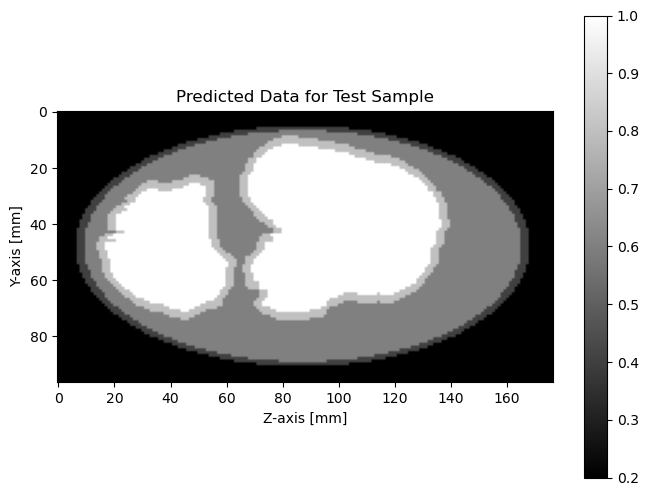

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8, 6))
img_pred = plt.imshow(X_train[0,:,:,1], cmap='gray')  # Plot predicted data slice
plt.title(f'Predicted Data for Test Sample')
plt.xlabel('Z-axis [mm]')
plt.ylabel('Y-axis [mm]')
plt.colorbar(img_pred)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import numpy as np

# Load the new dataset
new_dataset = np.load('new_image_dataset.npy')
print("New dataset shape:", new_dataset.shape)

# Define input (X) and output (Y) from the dataset
X_train = new_dataset  # Assuming new_dataset already has the input pairs
Y_train = y_train_1


Y_train = np.expand_dims(Y_train, axis=-1)  # Add channel dimension if necessary
print("Original X_train shape:", X_train.shape)
print("Original Y_train shape:", Y_train.shape)

# Resize X_train and Y_train to (96, 176)
X_train_resized = tf.image.resize(X_train, [96, 176]).numpy()
Y_train_resized = tf.image.resize(Y_train, [96, 176]).numpy()
print("Resized X_train shape:", X_train_resized.shape)
print("Resized Y_train shape:", Y_train_resized.shape)

import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_shape=(96, 176, 2), output_channels=1):
    inputs = tf.keras.Input(input_shape)

    # Encoder (downsampling path)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (upsampling path)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(output_channels, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

# Create the model
model = unet_model()
model.summary()







# # Define the U-Net model
# def unet(input_size=(96, 176, 2)):
#     inputs = Input(input_size)
#     c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
#     p1 = MaxPooling2D((2, 2))(c1)
#     c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
#     c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
#     p2 = MaxPooling2D((2, 2))(c2)
#     c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
#     c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
#     u1 = UpSampling2D((2, 2))(c3)
#     u1 = concatenate([u1, c2])
#     c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
#     c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
#     u2 = UpSampling2D((2, 2))(c4)
#     u2 = concatenate([u2, c1])
#     c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
#     c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
#     outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
#     model = Model(inputs=[inputs], outputs=[outputs])
#     return model
# input_size = (96, 176, 2)
# model = unet(input_size=input_size)
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# model.summary()
# history = model.fit(
#     X_train_resized, Y_train_resized,
#     batch_size=16,
#     epochs=20,
#     validation_split=0.2
# )
# model.save('unet_trained_model.h5')
# print("Training completed. Model saved as 'unet_trained_model.h5'.")
